In [178]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import plotly.express as px
from sklearn.ensemble import IsolationForest

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

#### Daten importieren mit Pandas

In [117]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')

#### Erster Blick auf die Daten und Kenngrößen

In [118]:
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB


####  ggf. NaN-Values ersetzen

In [120]:
if df.isnull:
    df.fillna(method = 'ffill')

#### Konvertierung in Pandas-Timestamp-Format (Änderung des Datentyps von 'object' in 'datetime64'

In [121]:
df['timestamp']=pd.to_datetime(df['timestamp'])


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


In [123]:
df = df.rename(columns={'value': 'demand'})

In [124]:
df.head()

,timestamp,demand
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


#### Resampling zur Verringerung der Datenmenge, nur Datenpunkte alle 60 Minuten werden betrachtet

In [125]:
df = df.set_index('timestamp').resample("H").mean().reset_index()

In [126]:
df.head()

,timestamp,demand
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


In [127]:
fig = px.line(df.reset_index(), x='timestamp', y='demand', title='NYC Taxi Anfragen')

fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

#### Einfügen zusätzlicher Spalten, um Zusammenhänge zwischen den Uhrzeiten und Wochentagen besser feststellen zu können

In [129]:
df['hour'] = df.timestamp.dt.hour

In [130]:
df['weekday'] = pd.Categorical(df.timestamp.dt.strftime('%A'), categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  5160 non-null   datetime64[ns]
 1   demand     5160 non-null   float64       
 2   hour       5160 non-null   int64         
 3   weekday    5160 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 126.4 KB


In [133]:
df.head()

,timestamp,demand,hour,weekday
0,2014-07-01 00:00:00,9485.5,0,Tuesday
1,2014-07-01 01:00:00,5433.0,1,Tuesday
2,2014-07-01 02:00:00,3346.5,2,Tuesday
3,2014-07-01 03:00:00,2216.5,3,Tuesday
4,2014-07-01 04:00:00,2189.5,4,Tuesday


In [134]:
df.tail()

,timestamp,demand,hour,weekday
5155,2015-01-31 19:00:00,28288.5,19,Saturday
5156,2015-01-31 20:00:00,24138.0,20,Saturday
5157,2015-01-31 21:00:00,24194.5,21,Saturday
5158,2015-01-31 22:00:00,26515.0,22,Saturday
5159,2015-01-31 23:00:00,26439.5,23,Saturday


#### Visualisierung der Nachfrage über einen gesamten Tag (im Durchschnitt)

<AxesSubplot:xlabel='hour'>

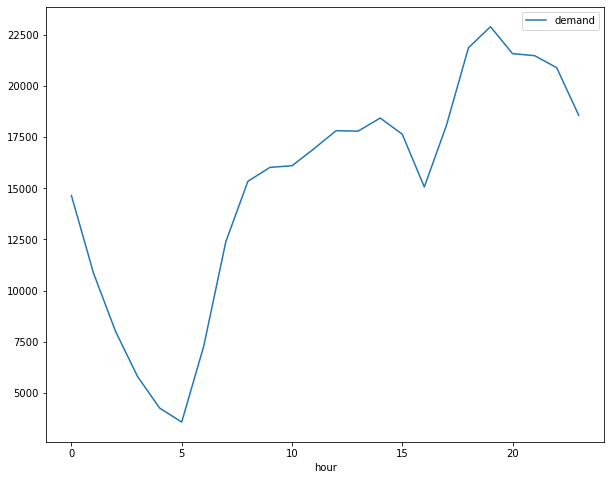

In [139]:
df[['demand','hour']].groupby('hour').mean().plot()

#### Visualisierung der Nachfrage über eine Woche (im Durchschnitt)

<AxesSubplot:xlabel='weekday'>

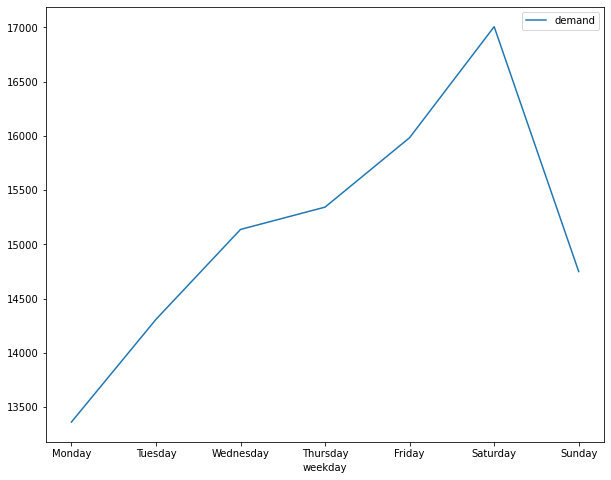

In [138]:
df[['demand','weekday']].groupby('weekday').mean().plot()

#### Visualisierung der unterschiedlich hohen Nachfrage abhängig vom Wochentag
man erkennt bspw. die höhere Auslastung am Wochenende bei Nacht

<AxesSubplot:xlabel='hour'>

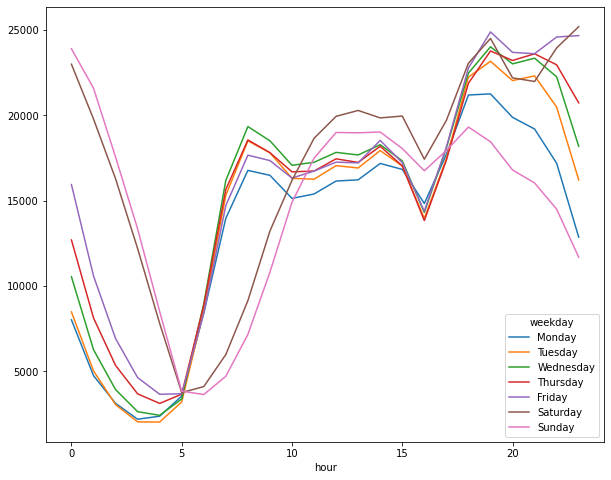

In [149]:
df.groupby(['hour', 'weekday']).mean()['demand'].unstack().plot()

#### Hinzufügen einer neuen Spalte, um den aktuellen Wert mit dem durchschnittlichen Wert zu dieser Stunde und an diesem Wochentag zu vergleichen

In [150]:
df_final = df.join(df.groupby(['hour', 'weekday'])['demand'].mean(), on = ['hour','weekday'], rsuffix = '_avg')

In [151]:
df_final

,timestamp,demand,hour,weekday,demand_avg
0,2014-07-01 00:00:00,9485.5,0,Tuesday,8483.709677
1,2014-07-01 01:00:00,5433.0,1,Tuesday,5028.193548
2,2014-07-01 02:00:00,3346.5,2,Tuesday,3052.112903
3,2014-07-01 03:00:00,2216.5,3,Tuesday,2039.580645
4,2014-07-01 04:00:00,2189.5,4,Tuesday,2031.258065
...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,24501.870968
5156,2015-01-31 20:00:00,24138.0,20,Saturday,22193.758065
5157,2015-01-31 21:00:00,24194.5,21,Saturday,21983.241935
5158,2015-01-31 22:00:00,26515.0,22,Saturday,23949.951613


#### Bekannte Anmalien, die gefunden werden sollen
```
NYC Marathon - 2014-11-02
Thanksgiving - 2014-11-27
Christmas - 2014-12-25
New Years - 2015-01-01
Snow Blizzard - 2015-01-26 and 2015-01-27```



#### prüft man die Werte, erkennt man bereits größere Abweichungen zum Durchschnitt

In [153]:
df_final.set_index('timestamp').loc['2014-11-02']

,demand,hour,weekday,demand_avg
timestamp,,,,
2014-11-02 00:00:00,24109.5,0,Sunday,23898.733333
2014-11-02 01:00:00,37204.5,1,Sunday,21593.533333
2014-11-02 02:00:00,12754.5,2,Sunday,17555.266667
2014-11-02 03:00:00,8955.5,3,Sunday,13350.550000
2014-11-02 04:00:00,5453.5,4,Sunday,8506.500000
2014-11-02 05:00:00,5174.0,5,Sunday,3837.450000
2014-11-02 06:00:00,4920.0,6,Sunday,3643.983333
2014-11-02 07:00:00,5592.0,7,Sunday,4711.300000
2014-11-02 08:00:00,7525.5,8,Sunday,7159.516667


In [154]:
df_final.set_index('timestamp').loc['2015-01-26':'2015-01-27']

,demand,hour,weekday,demand_avg
timestamp,,,,
2015-01-26 00:00:00,5907.0,0,Monday,8020.283333
2015-01-26 01:00:00,3649.5,1,Monday,4749.750000
2015-01-26 02:00:00,2310.0,2,Monday,3125.800000
2015-01-26 03:00:00,1949.5,3,Monday,2195.133333
2015-01-26 04:00:00,2165.5,4,Monday,2373.166667
2015-01-26 05:00:00,3723.0,5,Monday,3550.800000
2015-01-26 06:00:00,9146.0,6,Monday,8414.566667
2015-01-26 07:00:00,15835.5,7,Monday,13968.766667
2015-01-26 08:00:00,18804.5,8,Monday,16774.483333


#### Zusätzliche Spalte, um den Tag als Zahl zu speichern

In [157]:
df_final['day']=df.timestamp.dt.weekday

In [158]:
df_final

,timestamp,demand,hour,weekday,demand_avg,day
0,2014-07-01 00:00:00,9485.5,0,Tuesday,8483.709677,1
1,2014-07-01 01:00:00,5433.0,1,Tuesday,5028.193548,1
2,2014-07-01 02:00:00,3346.5,2,Tuesday,3052.112903,1
3,2014-07-01 03:00:00,2216.5,3,Tuesday,2039.580645,1
4,2014-07-01 04:00:00,2189.5,4,Tuesday,2031.258065,1
...,...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,24501.870968,5
5156,2015-01-31 20:00:00,24138.0,20,Saturday,22193.758065,5
5157,2015-01-31 21:00:00,24194.5,21,Saturday,21983.241935,5
5158,2015-01-31 22:00:00,26515.0,22,Saturday,23949.951613,5


#### Die Merkmale, die für den ML-Algoithmus verwendet werden, werden in 'data' gespeichert

In [159]:
data = df_final[['demand', 'hour', 'day']]

#### Definition des Modells (Isolation Forest) und Lernvorgang (.fit)
wichtiger Parameter: contamination legt fest, wie viele Anomalien etwa erwartet werden (d.h. Baumtiefe, bis zu der
ein Punkt noch als Anomalie klassifiziert wird

In [161]:
model =  IsolationForest(contamination=0.005, max_features=3, max_samples=0.8, n_estimators=200)
model.fit(data)

IsolationForest(contamination=0.005, max_features=3, max_samples=0.8,
                n_estimators=200)

#### Prediction gibt -1 für Anomalie zurück --> diese Punkte werden in neuer Spalte gespeichert

In [167]:
df_final['outliers']=pd.Series(model.predict(data)).apply(lambda x: 'yes' if (x == -1) else 'no' )

#### Alle Anomalien:

In [168]:
df_final.query('outliers=="yes"')

,timestamp,demand,hour,weekday,demand_avg,day,outliers
1488,2014-09-01 00:00:00,13763.0,0,Monday,8020.283333,0,yes
1631,2014-09-06 23:00:00,29418.5,23,Saturday,25192.516129,5,yes
2640,2014-10-19 00:00:00,27146.5,0,Sunday,23898.733333,6,yes
2977,2014-11-02 01:00:00,37204.5,1,Sunday,21593.533333,6,yes
4271,2014-12-25 23:00:00,7977.5,23,Thursday,20732.241935,3,yes
4413,2014-12-31 21:00:00,27559.5,21,Wednesday,23345.806452,2,yes
4416,2015-01-01 00:00:00,25850.0,0,Thursday,12698.500000,3,yes
4417,2015-01-01 01:00:00,29292.0,1,Thursday,8132.564516,3,yes
4418,2015-01-01 02:00:00,25753.5,2,Thursday,5350.209677,3,yes
4419,2015-01-01 03:00:00,22067.0,3,Thursday,3683.177419,3,yes


#### Vergleich mit Anomalien, die gefunden werden sollen
```
NYC Marathon - 2014-11-02
Thanksgiving - 2014-11-27
Christmas - 2014-12-25
New Years - 2015-01-01
Snow Blizzard - 2015-01-26 and 2015-01-27```



In [166]:
df_final

,timestamp,demand,hour,weekday,demand_avg,day,outliers
0,2014-07-01 00:00:00,9485.5,0,Tuesday,8483.709677,1,no
1,2014-07-01 01:00:00,5433.0,1,Tuesday,5028.193548,1,no
2,2014-07-01 02:00:00,3346.5,2,Tuesday,3052.112903,1,no
3,2014-07-01 03:00:00,2216.5,3,Tuesday,2039.580645,1,no
4,2014-07-01 04:00:00,2189.5,4,Tuesday,2031.258065,1,no
...,...,...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,24501.870968,5,no
5156,2015-01-31 20:00:00,24138.0,20,Saturday,22193.758065,5,no
5157,2015-01-31 21:00:00,24194.5,21,Saturday,21983.241935,5,no
5158,2015-01-31 22:00:00,26515.0,22,Saturday,23949.951613,5,no


#### Visulaisierung der detektierten Anomalien.
#### Man erkennt gut, dass nicht nur globale/punktuelle Anomalien, sondern auch Kontextanomalien detektiert werden

In [170]:
fig = px.scatter(df_final, x='timestamp', y='demand', color='outliers', hover_data=['weekday','hour','demand_avg'], title='NYC Taxi Demand')

fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

#### Genauere Untersuchung, um sinnvolle Grenze zur Anomalie-Definition festzulegen --> Ausgabe des konkreten Werts aus der Entscheidungsfunktion

In [171]:
score = model.decision_function(data)

In [172]:
score

array([0.11652102, 0.15400658, 0.16632275, ..., 0.15791235, 0.12923366,
       0.11375787])

#### Mit Hilfe des Histogramms kann die Verteilung der Ausreißer betrachtet werden und eine eigene Grenze/Threshold definiert werden, wann Punkte als Anomalie gesehen werden sollen

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   4.,   4.,   1.,   5.,   6.,   3.,   4.,
          8.,   9.,   9.,  16.,  17.,  28.,  32.,  40.,  52.,  71.,  95.,
         84., 119., 144., 201., 215., 283., 350., 422., 493., 495., 470.,
        418., 346., 273., 233., 158.,  47.]),
 array([-0.14854947, -0.14140035, -0.13425124, -0.12710212, -0.11995301,
        -0.11280389, -0.10565477, -0.09850566, -0.09135654, -0.08420743,
        -0.07705831, -0.0699092 , -0.06276008, -0.05561096, -0.04846185,
        -0.04131273, -0.03416362, -0.0270145 , -0.01986539, -0.01271627,
        -0.00556715,  0.00158196,  0.00873108,  0.01588019,  0.02302931,
         0.03017842,  0.03732754,  0.04447665,  0.05162577,  0.05877489,
         0.065924  ,  0.07307312,  0.08022223,  0.08737135,  0.09452046,
         0.10166958,  0.1088187 ,  0.11596781,  0.12311693,  0.13026604,
         0.13741516,  0.14456427,  0.15171339,  0.15886251,  0.16601162,
 

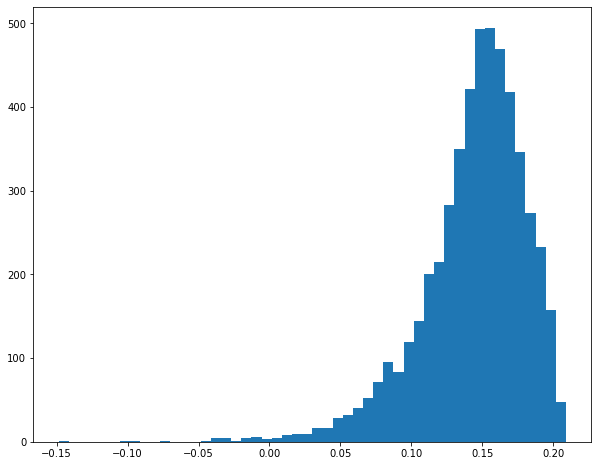

In [173]:
plt.hist(score, bins=50)

In [174]:
df_final['scores'] = score

In [175]:
df_final

,timestamp,demand,hour,weekday,demand_avg,day,outliers,scores
0,2014-07-01 00:00:00,9485.5,0,Tuesday,8483.709677,1,no,0.116521
1,2014-07-01 01:00:00,5433.0,1,Tuesday,5028.193548,1,no,0.154007
2,2014-07-01 02:00:00,3346.5,2,Tuesday,3052.112903,1,no,0.166323
3,2014-07-01 03:00:00,2216.5,3,Tuesday,2039.580645,1,no,0.169334
4,2014-07-01 04:00:00,2189.5,4,Tuesday,2031.258065,1,no,0.178335
...,...,...,...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,24501.870968,5,no,0.029739
5156,2015-01-31 20:00:00,24138.0,20,Saturday,22193.758065,5,no,0.154924
5157,2015-01-31 21:00:00,24194.5,21,Saturday,21983.241935,5,no,0.157912
5158,2015-01-31 22:00:00,26515.0,22,Saturday,23949.951613,5,no,0.129234


#### Festlegung der Grenze z.B. auf 0.02 durch Expertenwissen, man erkennt, dass jetzt weniger Punkte als Anomalie klassifiziert werden

In [177]:
df_final.query('scores<-0.02')

,timestamp,demand,hour,weekday,demand_avg,day,outliers,scores
1488,2014-09-01 00:00:00,13763.0,0,Monday,8020.283333,0,yes,-0.027060
1631,2014-09-06 23:00:00,29418.5,23,Saturday,25192.516129,5,yes,-0.027058
2977,2014-11-02 01:00:00,37204.5,1,Sunday,21593.533333,6,yes,-0.148549
4271,2014-12-25 23:00:00,7977.5,23,Thursday,20732.241935,3,yes,-0.020705
4416,2015-01-01 00:00:00,25850.0,0,Thursday,12698.500000,3,yes,-0.041258
4417,2015-01-01 01:00:00,29292.0,1,Thursday,8132.564516,3,yes,-0.097560
4418,2015-01-01 02:00:00,25753.5,2,Thursday,5350.209677,3,yes,-0.037259
4511,2015-01-04 23:00:00,8402.0,23,Sunday,11686.450000,6,yes,-0.027765
5035,2015-01-26 19:00:00,4565.5,19,Monday,21255.900000,0,yes,-0.028855
5036,2015-01-26 20:00:00,3630.5,20,Monday,19880.766667,0,yes,-0.034441
